In [ ]:
This notebook presents an application of the [pydiva2D](./pydiva2d.py) module to perform a 2D Diva analysis and then generate figures for the different input and output using the Basemap module.

In [1]:
import os
import logging
import pydiva2d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import subprocess
from importlib import reload
%matplotlib inline

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We set up the logger so that only error messages are displayed on screen.

In [2]:
logger = logging.getLogger('diva2D')
logger.setLevel(logging.ERROR)

# Prepare input files and directories

In this example the input files are already created and can be found in the *data* directory.

In [3]:
datadir = './data/'
datafile = os.path.join(datadir, 'MLD1.dat')
coastfile = os.path.join(datadir, 'coast.cont')
paramfile = os.path.join(datadir, 'param.par')

We also create a directory *figures* where we will save the plots.

In [17]:
figdir = './figures/'
if os.path.exists(figdir):
    logger.debug("Directory {0} already exists".format(figdir))
else:
    logger.debug("Creating directory {0}".format(figdir))
    os.makedirs(figdir)

## Create paths and file names

We create the paths for the Diva directories and files:

In [4]:
divadir = "/home/ctroupin/Software/DIVA/diva-4.7.1"
DivaDirs = pydiva2d.DivaDirectories(divadir)
DivaFiles = pydiva2d.Diva2Dfiles(DivaDirs.diva2d)

## Read input files

Let's read the information from the input files.<br>
For each input file, we first creat an object (i.e., **Data**, **Contour** and **Param**) that will allow us to perform operations such as 
* reading, 
* writing, 
* plotting, 
* getting a description.

In [5]:
Data = pydiva2d.Diva2DData()
Data.read_from(datafile)
Contour = pydiva2d.Diva2DContours()
Contour.read_from(coastfile)
Param = pydiva2d.Diva2DParameters()
Param.read_from(paramfile)

For example with the parameters:

In [6]:
Param.describe()

Correlation length: 1.0
icoordchange: 2
ispec: 0
ireg: 2
Domain: x-axis: from 27.0 to 42.0 with 151 steps of 0.1
Domain: y-axis: from 40.0 to 47.5 with 76 steps of 0.1
Exclusion value: -99.0
Signal-to-noise ratio: 1.0
Variance of the background field: 0.0


# Make the analysis

We write the inputs to the corresponding files using the *write_to* functions available for each type of input:

In [7]:
Data.write_to(DivaFiles.data)
Param.write_to(DivaFiles.parameter)
Contour.write_to(DivaFiles.contour)

## Generate the mesh

We simply call the **divamesh** script:

In [9]:
subprocess.Popen("./divamesh", cwd=DivaDirs.diva2d, shell=True)

and we create a new **Mesh** object using the information from the 2 files generated by the mesh generation:

In [8]:
Mesh = pydiva2d.Diva2DMesh(DivaFiles.mesh, DivaFiles.meshtopo)

Similarly to the parameter, we can obtain a description of the mesh:

In [9]:
Mesh.describe()

Number of nodes: 6447
Number of interfaces: 14059
Number of elements: 7592


## Perform the analysis

We call the **divacalc** script:

In [10]:
subprocess.Popen("./divacalc", cwd=DivaDirs.diva2d, shell=True)

and load the results in a new object **Analysis**:

In [10]:
Analysis = pydiva2d.Diva2DResults(DivaFiles.result)

# Create the plots

In this example the plots are created using the Basemap module.<br>
All the objects we created have a function *add_to_plot* that takes into account, if it is defined, the selected projection in Basemap.

## Initialise the projection

We will center the map on the region specified by the parameters and with a Mercator projection.<br>
Type `Basemap?` for a list of available projections and options.

In [14]:
m = Basemap(projection='merc', llcrnrlon=Param.xori, llcrnrlat=Param.yori, urcrnrlon=Param.xend,
            urcrnrlat=Param.yend, resolution='i')

## Data points

We use the function **add_to_plot** with 'm' (the projection) as an optional argument.

/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


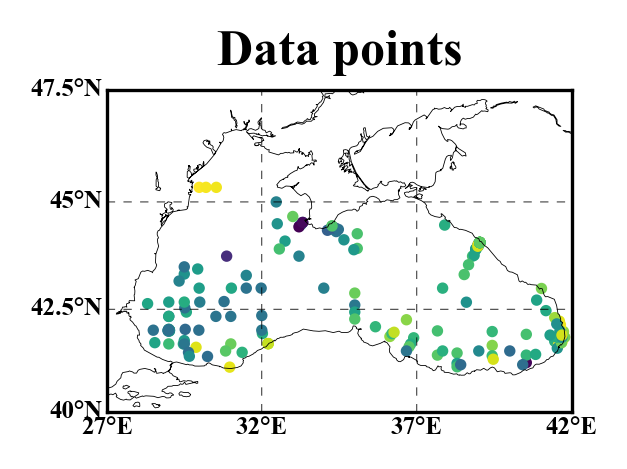

In [18]:
fig = plt.figure(figsize=(2, 2))
Data.add_to_plot(m=m, s=3)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=6)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=6)
m.drawcoastlines(linewidth=0.2)
plt.title('Data points')
plt.savefig(os.path.join(figdir, 'datapoints.png'))
plt.show()
plt.close()

## Contours

/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


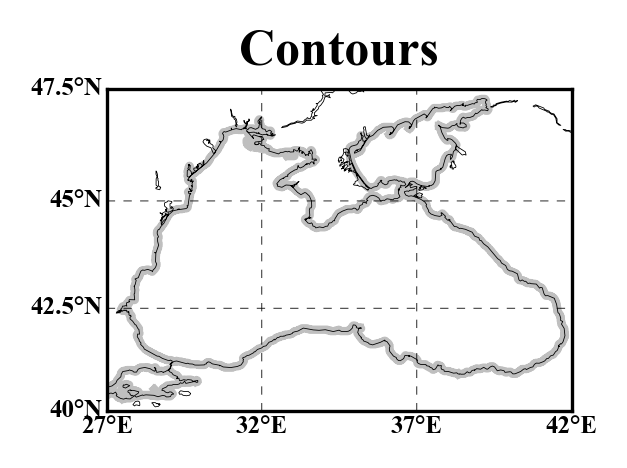

In [19]:
fig = plt.figure(figsize=(2, 2))
Contour.add_to_plot(m=m, linewidth=2, color='.75')
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=6)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=6)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.title('Contours')
plt.savefig(os.path.join(figdir, 'contours.png'))
plt.show()
plt.close()

## Finite element mesh

To create the plot, we add the option *m* in the **add_to_plot** function.<br>
Take into account that this plot generation is relatively slow.

In [23]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(111)
Mesh.add_to_plot(ax, m, linewidth=0.25)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=6)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=6)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.title("Mesh")
plt.savefig(os.path.join(figdir, 'mesh.png'))
plt.show()
plt.close()

## Analysed field

/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


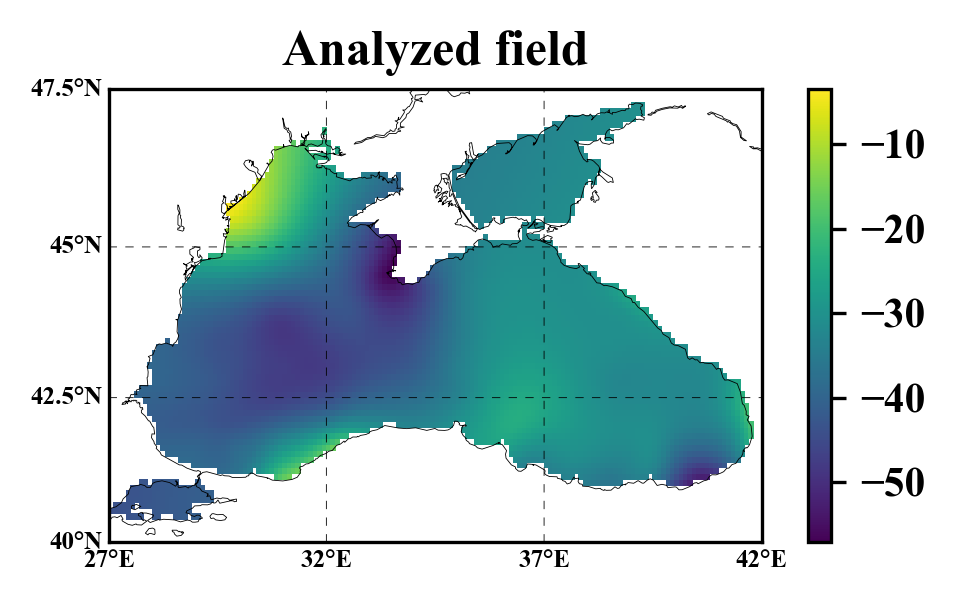

In [24]:
fig = plt.figure(figsize=(4, 2))
ax = plt.subplot(111)
Analysis.add_to_plot(ax=ax, m=m)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=6)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=6)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.title('Analyzed field')
plt.savefig(os.path.join(figdir, 'analysis.png'))
plt.show()
plt.close()

# Final remarks

* The different elements of the plot can be combined in many ways (see example below).
* All the plots can be easily modified by adapting the diffent options: colors, projection, font size etc.

In [25]:
fig = plt.figure(figsize=(4, 2))
ax = plt.subplot(111)
Analysis.add_to_plot(ax=ax, m=m, vmin=-60, vmax=-5)
Mesh.add_to_plot(ax=ax, m=m, alpha=0.2, linewidth=0.25)
Contour.add_to_plot(m=m, linewidth=1, color='0.75')
Data.add_to_plot(m=m, s=3, vmin=-60, vmax=-5)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=6)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=6)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.title('Analyzed field, mesh,\n contour and data')
plt.savefig(os.path.join(figdir, 'AnalysisMeshData.png'))
plt.close()

/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 